In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from jax import random

import warnings
warnings.filterwarnings('ignore')


plt.rcParams['figure.constrained_layout.use'] = True
import seaborn as sns
sns.set_context("notebook")

In [5]:
URL = "https://gist.githubusercontent.com/ucals/" + "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"+ "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"+ "osic_pulmonary_fibrosis.csv"
#download the url and save it as a csv file
train = pd.read_csv(URL)
train.head()


,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train[['Patient', 'Weeks']], train['FVC'], train_size=0.8, random_state=42)
#print size of train and test data
print("x_train size:", x_train.shape)
print("x_test size:", x_test.shape)
# Number of unique patients
x_train['Patient'].nunique()

x_train size: (1239, 2)
x_test size: (310, 2)


176

In [11]:
import numpyro.distributions as dist
sample_weeks = x_train["Weeks"].values
sample_fvc = y_train.values
x_test1=x_test["Weeks"].values
y_test1=y_test.values
x_test1=np.sort(x_test1)

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(sample_weeks.reshape(-1, 1), sample_fvc)

LinearRegression()

Text(0, 0.5, 'FVC')

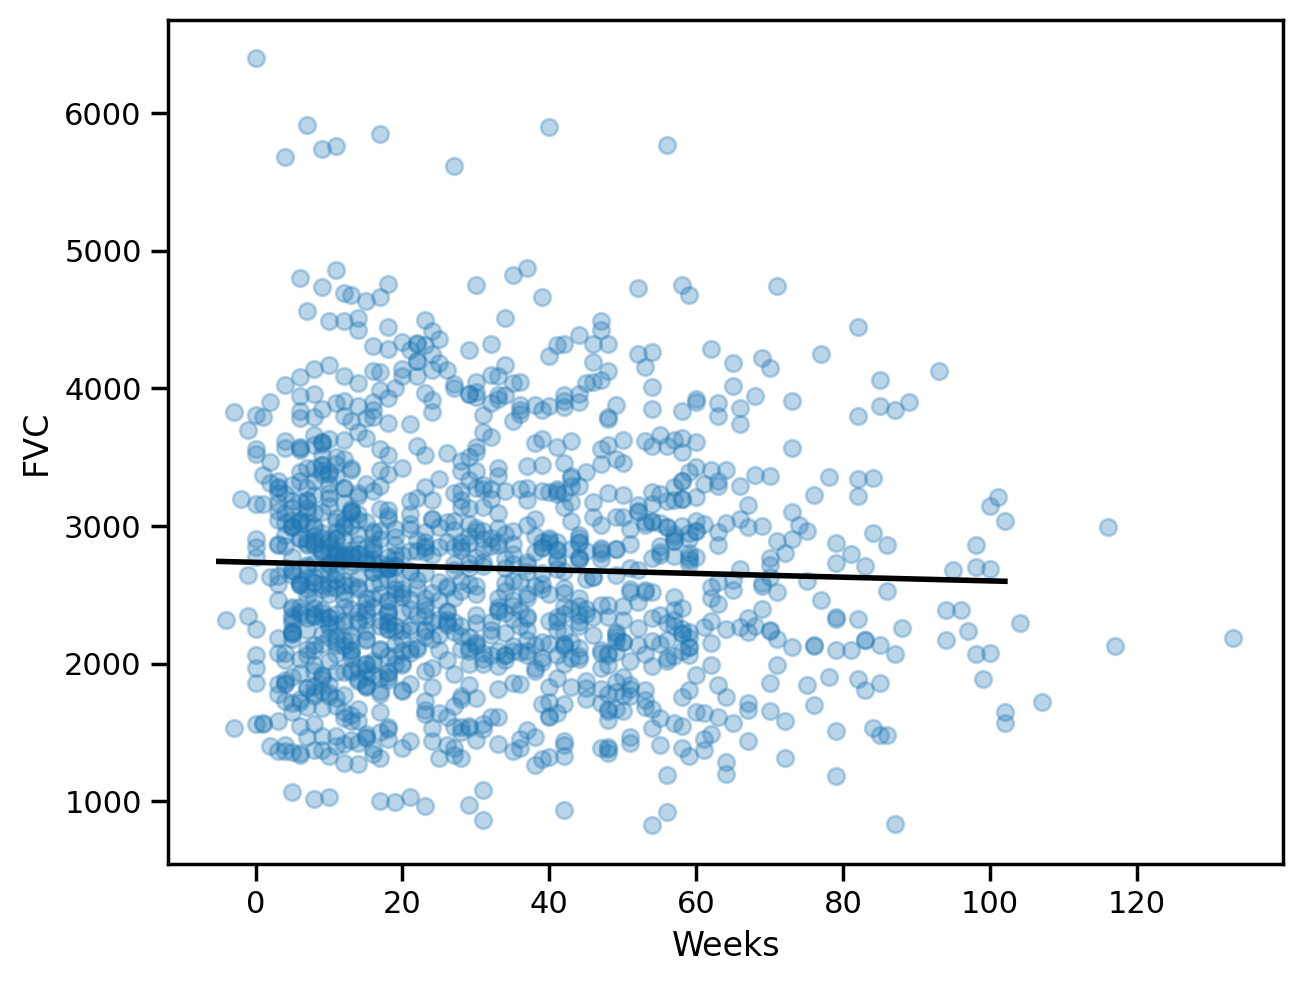

In [12]:
plt.scatter(sample_weeks, sample_fvc, alpha=0.3)
plt.plot(x_test1, lr.predict(x_test1.reshape(-1, 1)), color="black", lw=2)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [13]:
from sklearn.metrics import mean_absolute_error

maes = {}
maes["LinearRegression"] = mean_absolute_error(sample_fvc, lr.predict(sample_weeks.reshape(-1, 1)))
maes

{'LinearRegression': 668.6480002710241}

### pooled model 

In [14]:
try:
    import numpyro
except ImportError:
    %pip install numpyro
    import numpyro

In [16]:
def pooled_model(sample_weeks, sample_fvc=None):
    α = numpyro.sample("α", dist.Normal(0., 500.))
    β = numpyro.sample("β", dist.Normal(0., 500.))
    σ = numpyro.sample("σ", dist.HalfNormal(100.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", dist.Normal(α + β * sample_weeks, σ), obs=sample_fvc)
    return fvc

# # Render the model graph
# numpyro.render_model(pooled_model, model_kwargs={"sample_weeks": sample_weeks, "sample_fvc": sample_fvc},
#                 render_distributions=True,
#                 render_params=True,
#                 )


In [17]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
x_train["patient_code"] = patient_encoder.fit_transform(x_train["Patient"].values)
sample_patient_code =x_train["patient_code"].values
sample_patient_code

array([142, 119, 131, ...,  97, 165, 128])

In [18]:
from numpyro.infer import MCMC, NUTS, Predictive
nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=2000)
rng_key = random.PRNGKey(0)

: 